# Introduction
blixt_rp is a python library designed to help you do quantitative seismic interpretation and rock physics mostly based on well log data. 

In essence it allows you to:
- work with well log data 
- extract statistics from individual or many stratigraphies across multiple wells
- extract depth trends across multiple wells and stratigraphies for any well log 
- do fluid substitution
- apply rock physics functions
- Chi angle analysis
- seismic modeling of 1 and quasi-2D models

The workflow is based on the usage of a central project table, which contains the most important settings and information for doing quantitative interpretation and AVO modelling.

## Installation
First install the utility library
```
pip3 install git+https://github.com/emblixt/blixt_utils.git
```
Then install the master, or development, version of blixt_rp
```
pip3 install git+https://github.com/emblixt/blixt_rp.git
```
or
```
pip3 install git+https://github.com/emblixt/blixt_rp.git@dev
```

## Project table
All wells used in a project, and which well logs to use from each well (with voluntary renaming to get consistent log names across project), and much more information, is stored in the project table. This makes it easy for you go see what data that has been used for what, and have a documented history of work.

The Excel sheet *project_table.xlsx*, in the *excels* folder of the install directory, is an example of such a project table. 
As shown below, this table contains multiple sheets:
- *Well settings*
 - Determine which wells are used and how they are plotted
- *Well logs*
 - Import las files and determine which logs to use, and their naming, for each well
- *Well paths*
- *Checkshots*
- *Regressions*
- *Templates*
 - Determine how the logs should be colored and plotted
- *Fluids*
- *Fluid mixtures*
- *Minerals*
- *Mineral mixtures*
- *Utils*
 - Utilities for the excel file itself.

most of them are optional to begin with

First you have to define the names of the wells you like to use in the project, which you determine in the *Well settings* sheet

<img src="images/WellSettings.png" />

- *Column A*: **Use** 
 - Determines which wells to use in the current analysis

The names are arbitrary, but each well name needs to be unique, and will be used throughout the project.
Also set the color and plotting symbol of the wells. The other information is not mandatory

Then, the *Wells logs* sheet determines which logs we should use for each well, and from which las file to load them

<img src="images/ProjectTable.png" />

- *Column A*: **Given well name**
 - Is the name of this well to use by Python. Taken from the *Well settings* sheet. 
 - It is possible to repeat this name, e.g. *Well_A* is used in both row 3 and 4, as we are loading data from several las files to the same well
 - The well name must be "the same" in the las files, and tops file. But Python tries to be smart and translates names like *6506/4-3 S* to *6506_4_3S* through out the workflow
-*Column B*: **Use this file**
 - Allows the user to switch between different las files. **Please note** that multiple las files for one well are allowed, and most often necessary.
- *Column C*: **las file**
 - Contains the pathname of the las file to load
- *Column D - Q*: *log types*
 - *Log types* (e.g. **P velocity**)  are used to group logs of similar type, like the log types of RokDoc. This is a comma-separated list of log names. These log names must exist in the specified las file.
 - It is possible to add any number of log types by adding a column to the excel sheet.
 - If a log have different names in different las file, you can **translate log names** by using *rename pair*(s) in the log name. E.G. the shale volume is named *VCL* in well A, B and C, but *VSH* in well E and F, therefore the *VSH->VCL* rename pair is given to h.
- *Column R*: **Note**
 - A note that will follow the well in the project.

Necessary imports

In [1]:
import os
import sys

# the following two lines are only for testing dev version of blixt_utils & blixt_rp
sys.path.append('C:\\Users\\marten\\PycharmProjects\\blixt_utils')
sys.path.append('C:\\Users\\marten\\PycharmProjects\\blixt_rp')

import blixt_utils.io.io as uio
import blixt_rp.core.well as cw
from blixt_rp.core.well import Project
from blixt_rp.plotting import plot_rp as prp
from blixt_rp.plotting import plot_logs as ppl

## Create a project

In [2]:
wp = Project(
    name='MyProject',  
    project_table='excels/project_table.xlsx',
    #working_dir='X:/Some/File path/On your/system'
)

All keywords of *Project()* are optional.

By default a project named *test* is created where this python library is installed, and uses the same folder as *working_dir*, and takes the *excels/project_table.xlsx* as project table.

The keywords to *Project* are:
- *working_dir* - the folder where the project is situated. It can be anywhere on your system.
- *project_table* - full or relative path name of the project table (.xlsx) explained in the top of this notebook
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file (log file with default name *\<PROJECT NAME\>_log.txt*)
- *load_from* - Full pathname of existing log file from previously set up project. Other input parameters, except log_to_stdout, are ignored

By using the *load_from* keyword, old projects can be opened. So if the above project *MyProject* had been created before, and with some work done to it, it can be reloaded using the following code (remove the '# ' first if you want to reload)

In [3]:
# wp = Project(load_from='MyProject_log.txt')

In nearly all projects, it is necessary to write some supporting Python code that are unique for each projects.

My recommedation is therefore to store your supporting Python code in a *\<PROJECT NAME\>.py* file, store it in the working directory, and add the working directory to the Python path

In [4]:
sys.path.append(wp.working_dir)

The Python file *MyProject.py* contains two scripts; *new_project()* and *init()*.
Where *new_project()* is doing exactly the same as in Cell 2 above, and *init()* performs the steps we are going through below.

## Log tables
As seen in the examples above, it is possible to load several logs under each log type. 
In some  calculations and plots that follows, it becomes necessary to choose only one log per log type, and you can achieve that by defining  a *log table* dictionary: 

In [5]:
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vcl'}

which can be used by many subsequent functions. 

## Load selected wells


In [6]:
wells = wp.load_all_wells()

c:\program files\python37\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### Data structure
<img src="images/Well object structure.png" />

The above result is a dictionary of *Well* objects. 

To see which wells are included, use

In [7]:
print(list(wells.keys()))

['WELL_A', 'WELL_B', 'WELL_C', 'WELL_F']


and to pick out one specific well use

In [8]:
this_well = wells['WELL_A']
print(type(this_well))
print(this_well.header)

<class 'blixt_rp.core.well.Well'>
             name: AttribDict({'value': 'WELL_A', 'unit': '', 'desc': 'Well name'})
    creation_info: AttribDict({'value': 'Created by marten, at DESKTOP-7JFC02N, on 2023-06-13T00:23:58.748011, using version 1.0.0', 'unit': '', 'desc': 'Creation info'})
    creation_date: AttribDict({'value': '2023-06-13T00:23:58.748011', 'unit': 'datetime', 'desc': 'Creation date'})
modification_date: AttribDict({'value': '2023-06-13T00:24:05.530905', 'unit': 'datetime', 'desc': 'Modification date'})
             null: AttribDict({'value': -999.25, 'unit': '', 'desc': 'Null Value'})
             comp: AttribDict({'value': 'COMPANY NAME', 'unit': '', 'desc': 'OPERATOR'})
             well: AttribDict({'value': 'WELL_A', 'unit': '', 'desc': 'WELL'})
              loc: AttribDict({'value': 'Norway', 'unit': '', 'desc': 'LOCATION - AREA'})
              fld: AttribDict({'value': 'A NAME', 'unit': '', 'desc': 'Field Name'})
             ctry: AttribDict({'value': 'NOR', '

The header of a well contains information specific to that well that we have retrieved while reading in the las file(s).
Note, that sometimes las file lack information about location and/or seawater depth, etc. which is why these most important settings can be specified in the *Well settings* of the project table.

The header is of a Header type, but its children can be accessed both as if it was a dictionary or directly, e.g.

In [9]:
print(this_well.header['date'])
print(this_well.header.date)

AttribDict({'value': None, 'unit': '', 'desc': 'WELL DATE'})
AttribDict({'value': None, 'unit': '', 'desc': 'WELL DATE'})


Each Well object can contain several *Blocks*. The Blocks themself contains log curves, but within each Block, all log curves have the same start, depth, and step values.

If you read in multiple las files to a single well (like *WELL_E* in the current project table), and these have slightly different start, stop or step values, the reading will try to crop, or extend, and if necessary, resample the log curves to fit the first las file that was read. 

By the default, the Block is called *Logs*, and if you want to read in different kinds of well data, like poro-perm tables, these can be added to the same well, but under a different Block.

To list the Blocks within a well, use

In [32]:
print(this_well.block.keys())

dict_keys(['Logs'])


This well only contain one Block member, which has the default name *Logs*.

To look at the content of this Block, you can start by pointing a variable to this Block, so that it is easier to work with it

In [33]:
this_block = this_well.block['Logs']
print(this_block.keys())

dict_keys(['supported_version', 'name', 'well', 'masks', 'header', 'logs'])


In [34]:
type(this_block.logs['vp_dry'])

blixt_rp.core.log_curve.LogCurve

The *header* contain information about the start, stop and step values used

In [35]:
print(this_block.header)

             name: AttribDict({'value': 'Logs', 'unit': '', 'desc': 'name'})
    creation_info: AttribDict({'value': 'Created by marten, at DESKTOP-7JFC02N, on 2023-06-11T00:52:19.524501, using version 1.0.0', 'unit': '', 'desc': 'Creation info'})
    creation_date: AttribDict({'value': '2023-06-11T00:52:19.524501', 'unit': 'datetime', 'desc': 'Creation date'})
modification_date: AttribDict({'value': '2023-06-13T00:20:18.842208', 'unit': 'datetime', 'desc': 'Modification date'})
             strt: AttribDict({'value': 295.0, 'unit': 'm', 'desc': 'START DEPTH'})
             stop: AttribDict({'value': 2636.1688, 'unit': 'm', 'desc': 'STOP DEPTH'})
             step: AttribDict({'value': 0.1524, 'unit': 'm', 'desc': 'STEP DEPTH'})
             well: WELL_A
    orig_filename: AttribDict({'value': 'test_data/Well A.las, test_data/Well A more data.las', 'unit': '', 'desc': 'orig_filename'})


To extract for example the start value of this well, use

In [36]:
start = this_block.header.strt.value
print(start)

295.0


## load well path, deviation files
Well path, or deviation, files can be added to the project to get information about the well trajectory. 

They are listed in the *Well paths* sheet of the project table
<img src="images/Well paths sheet.png" />

The *file format* "General ASCII" allow you to specify the columns to extract True Vertical Depth (TVD), Measured Depth (MD) and inclination, from. These data are interpolated so that it matches the resolution of the other data in the given *Block*


In [7]:
# calculate and add well path
for wname in list(wells.keys()):
    wells[wname].add_well_path(wp.project_table, verbose=False)

By setting *verbose* to *True*, plots are generated to show the quality of the interpolation.

Of course, the well trajectory is not strictly necessary at this stage, but will be so when starting to extract depth trends in well log data.

## Load time-depth relations, checkshot files
In a similar fashion, checkshot files can be loaded to give the time-depth relation of each well. These are also not strictly necessary, but will be so when creating synthetic seismic from the elastic properties in the well.

The checkshots are listed in the *Checkshots* sheet of the project table:

<img src="images/Checkshots sheet.png" />

And follows the same standard as for the well path files.

In [8]:
# calculate and add twt
for wname in list(wells.keys()):
    wells[wname].add_twt(wp.project_table, verbose=False)


The well path information and Two- (or One-) Way Time can also be provided through las files in the *Well logs* sheets if available.

## Load the project templates
This action combines the well settings in the *Well settings* sheet (described in the start) with the log templates defined in the *Templates* sheet

<img src="images/LogTemplates.png" />

**Note** that the *unit* is typically taken from the las files themself, and these templates are only occasionally used

In [9]:
templates = uio.project_templates(wp.project_table)


## Load working intervals
The working intervals for each well is specified in the *Working intervals* sheet of the project table.

<img src="images/ProjectTable_working_intervals.png" />

In the above example, the working intervals are defined through:
- *Column A*: **Use** 
 - This column in not is use in the current version
- *Column B*: **Given well name**
 - Is the name of wells in the project, as defined in the *Wells table* sheet.  
- *Column C*: **Interval name**
 - name of the working interval
- *Column D & E*: **Top depth** & **Base depth**
 - Depth in meters MD to top and base of the working interval
- *Column F*: **Source**
 - Optional. Use it as a reminder of where the data comes from 
- *Column G*: **Notes**
 - Optional.  
 
The first five rows of this sheet should not be modified.

This sheet can be generated automatically by importing tops from either Petrel, RokDoc or npd.no.  How that is done is not covered here.

The working intervals are loaded through

In [10]:
wis = uio.project_working_intervals(wp.project_table)

## Define cutoffs
Cut offs that are used to classify the data (e.g. sands or shales).

In [11]:
cutoffs_sands = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
cutoffs_shales = {'Volume': ['>', 0.5], 'Porosity': ['<', 0.1]}

In the example above, the clay volume must be below 0.5, and the porosity must be above 0.1, to count as a sand

Each log type specified in the cutoff (e.g. *Volume*) through the log_table, e.g. 
```
log_table = {'P velocity': 'vp_dry', ... 'Porosity': 'phie', 'Volume': 'vcl'}
```
must have its associated logname (e.g. *vcl*) existing in the .las files

## Plotting data

To check which logs exists in the wells, in one specific working interval, use the command

INFO: Extract water depth in well WELL_A from templates
INFO: Extract kb in well WELL_A from templates
INFO: Extract kb in well WELL_B using key: edf, with value 23.0 (<class 'float'>) [m].
INFO: Extract kb in well WELL_C using key: edf, with value 23.0 (<class 'float'>) [m].
INFO: Extract water depth in well WELL_F from templates
INFO: Extract kb in well WELL_F from templates


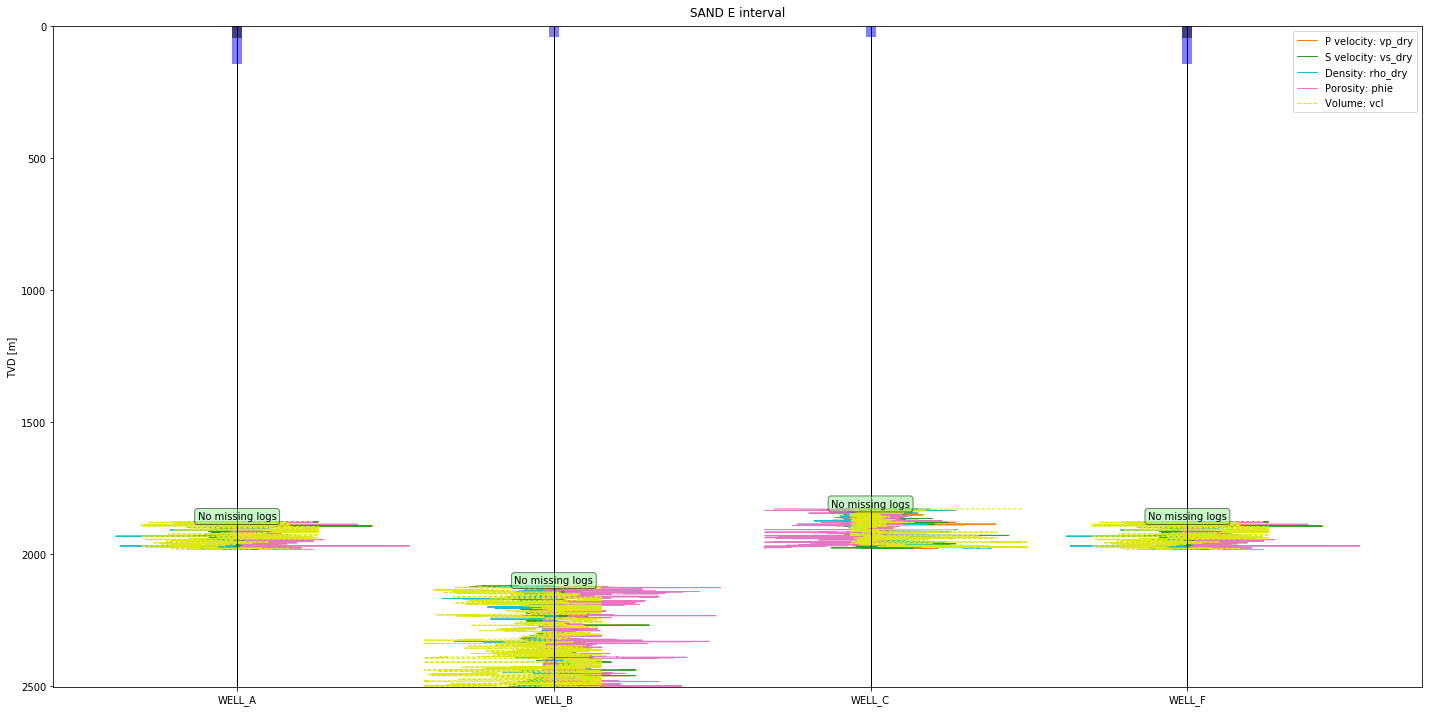

In [10]:
ppl.overview_plot(wells, log_table, wis, 'SAND E', templates, log_types=list(log_table.keys()))

gives you an overview whether the specified logs are present in the requested working interval, and what depth the interval is at.
If logs specified in the log table are lacking in one of the wells in this interval, a warning note is raised.

The color and linestyle of the individual logs are determined by the settings in the Templates sheet. Solid vertical lines indicate that the depth is in MD, and not TVD. For wells with TVD information, the vertical line is thinner and dashed.
If the Kelly bushing and water depth are specified in the Well settings sheet, these are displayed as shown for WELL_A 

For a more detailed plot, with synthetic seismogram, use the following function. 

INFO: Using real twt data
{'Gamma ray': 'gr', 'Inclination': 'inc'}
[[0.0, 350.0], [None, None]]
1:  0
1:  1
limits [None, None]
{'Resistivity': ['rdep', 'rmed', 'rsha']}
[[0.2, 200.0]]
1:  0
1:  0
1:  0
1:  0


C:\Users\marten\AppData\Roaming\Python\Python37\site-packages\bruges\filters\wavelets.py:204: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


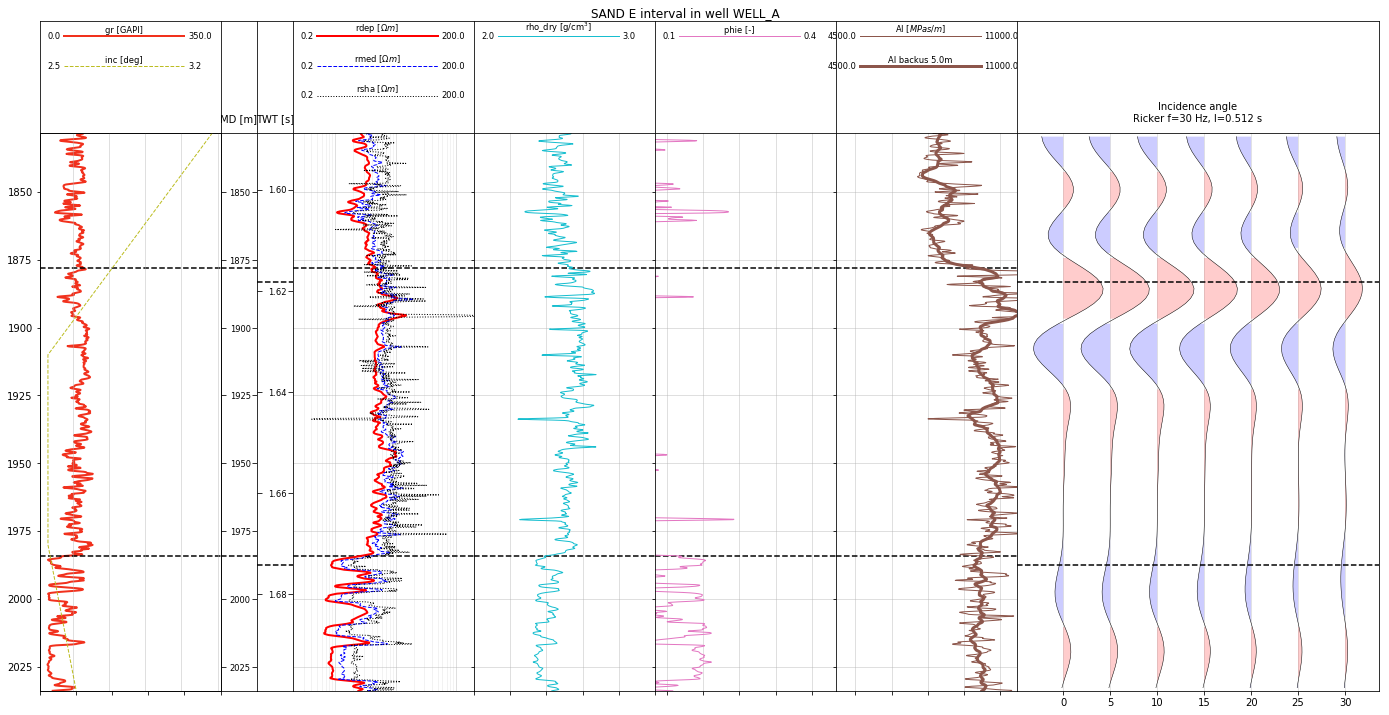

In [12]:
ppl.plot_logs(wells['WELL_A'], log_table, wis, 'SAND E', templates)

For a simple plot of a log versus depth, for a single well, use the following command

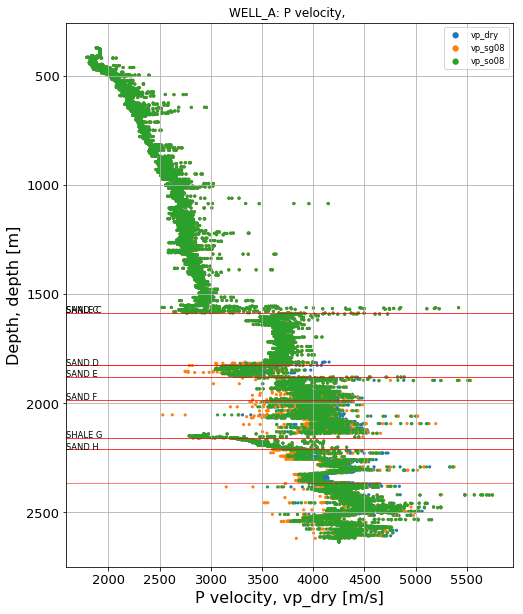

In [12]:
w = wells['WELL_A']
w.depth_plot('P velocity', wis=wis)

In python command line, these plots are interactive and can be zoomed and panned.

If you are interested in a specific working interval, you can create a mask that focus on this, and replot with that mask applied

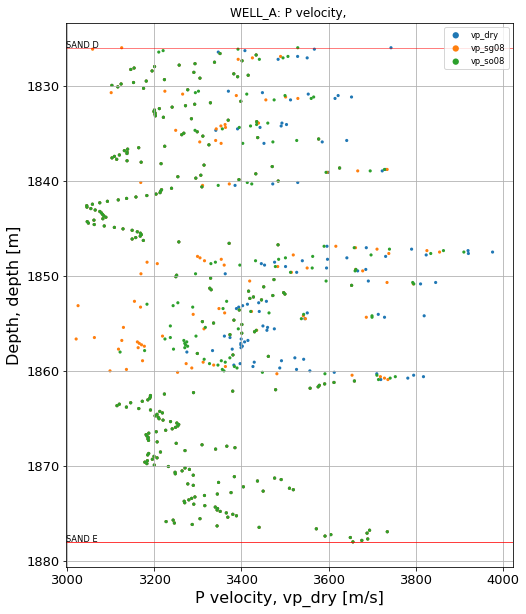

In [13]:
w.calc_mask({}, 'D sands', wis=wis, wi_name='SAND D')
mask = w.block['Logs'].masks['D sands'].data
w.depth_plot('P velocity', wis=wis, mask=mask, show_masked=False)

If you instead are interested in a mask applied on values, use the following

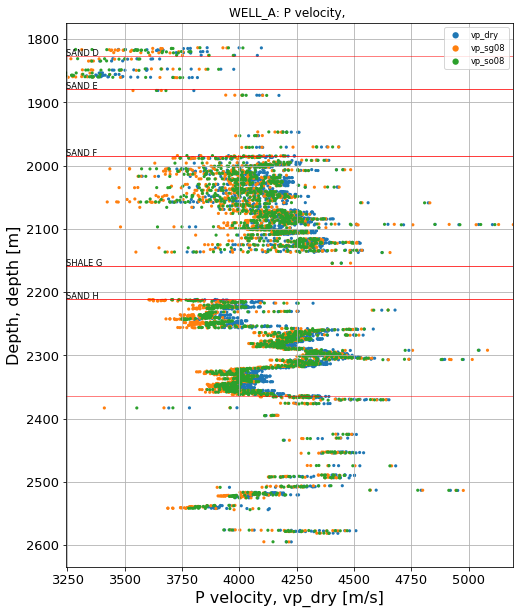

In [16]:
w.calc_mask(cutoffs_sands, 'sands', log_table=log_table)
mask = w.block['Logs'].masks['sands'].data
w.depth_plot('P velocity', wis=wis, mask=mask, show_masked=False)

To plot AI vs. Vp/Vs in a specific interval, you can use this functionality 

Plotting well WELL_A
Plotting well WELL_B
Plotting well WELL_C


(False, <matplotlib.legend.Legend at 0x22907411408>)

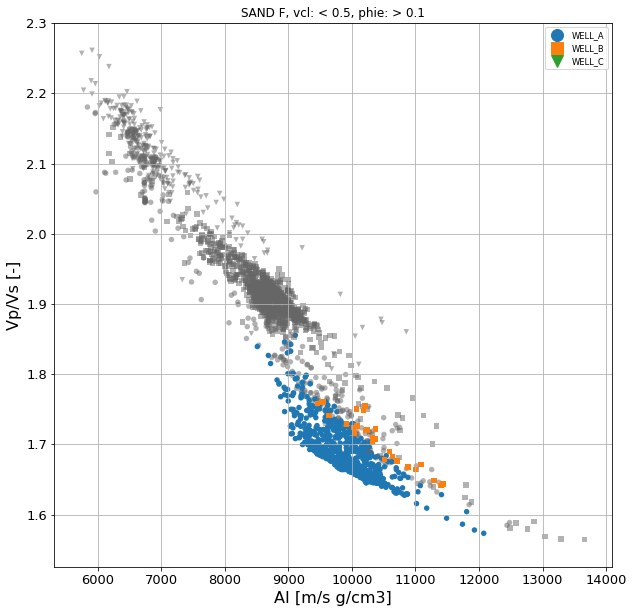

In [17]:
prp.plot_rp(
    wells,
    log_table,
    wis,
    'SAND F',
    cutoffs_sands,
    templates,
    plot_type='AI-VpVs',
    show_masked=True,
    edge_color=False
)